![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Project - Movies Genres Classification

This project will use a set of movies genres data . Each observation has the titile of the movie, year of the movie,  title plot and the different genres of the movie (a movie might be classifief to multiples genres). For instance:

Title: 'How to Be a Serial Killer'</br>
Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'</br>
Genres: 'Comedy', 'Crime', 'Horror'

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)


The idea is to use this data in order to predict the likely of a movie belongs to a genre given its plot.

Thank to Professor Fabio González, Ph.D. and his student John Arevalo by providing  this dataset (Uniandes). See https://arxiv.org/abs/1702.01992


## CODING


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# libraries to use
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#Reading datasets
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

year      0
title     0
plot      0
genres    0
rating    0
dtype: int64


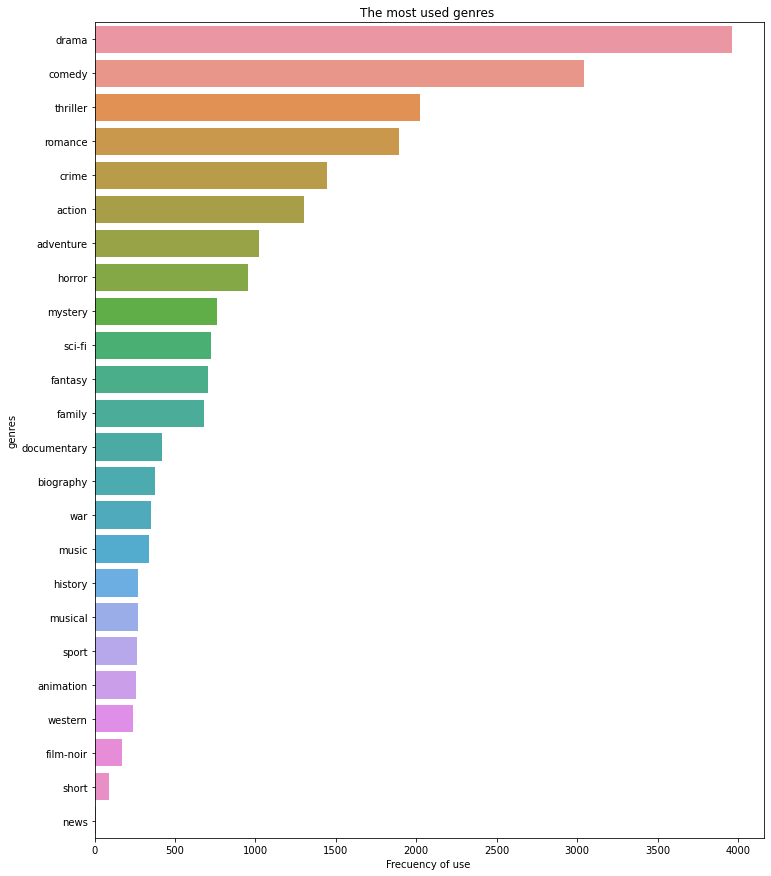

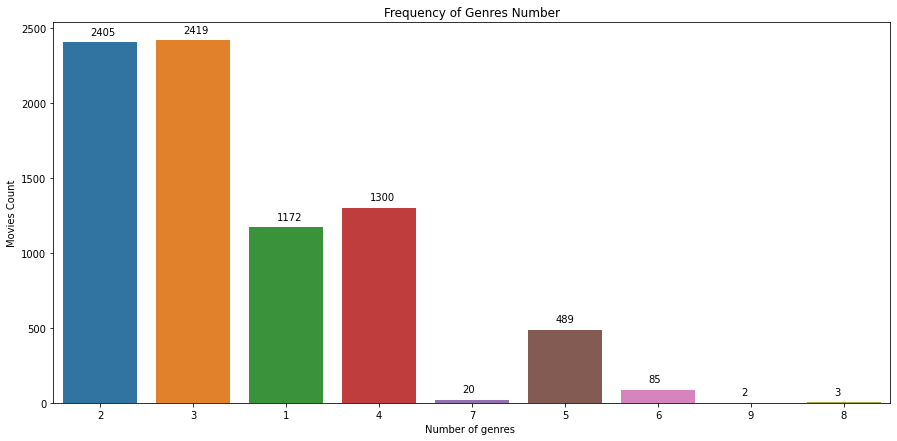

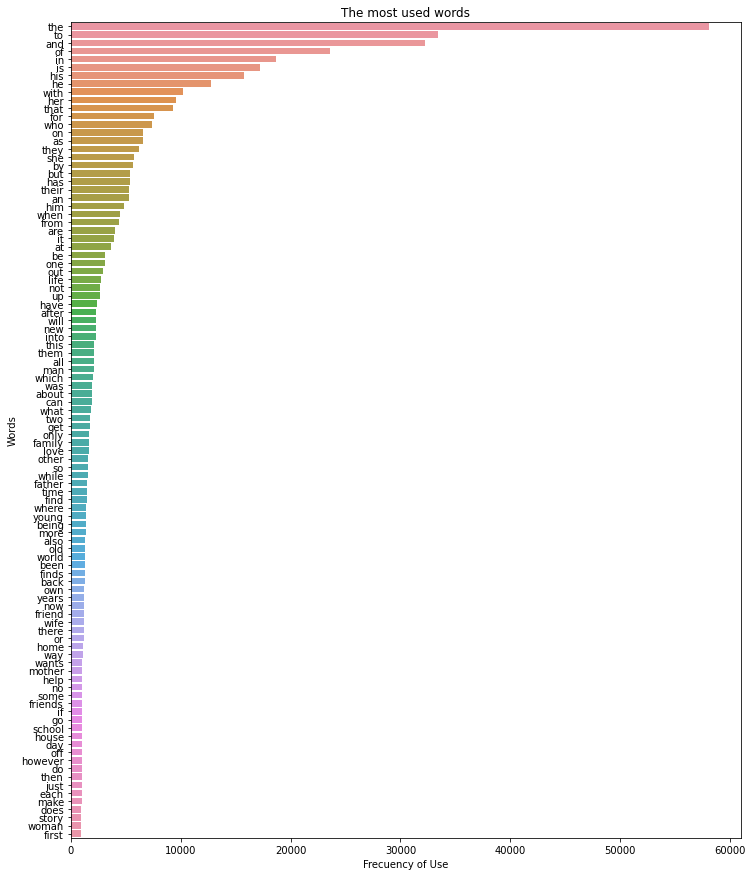

Len of the vocabulary 39646


In [ ]:
# Data Visualization
dataTraining.head()
dataTraining.describe().T
#Completeness level
print(dataTraining.isnull().sum())

# Validate if the column genre has spaces or is empty. If so, this row does not come handy for our prediction
dataTraining=dataTraining[~(dataTraining['genres'].str.len()==0)]
dataTraining=dataTraining[~dataTraining['genres'].str.isspace()]
# Validate if the column plot has spaces or is empty. If so, this row does not come handy for our prediction
dataTraining=dataTraining[~(dataTraining['plot'].str.len()==0)]
dataTraining=dataTraining[~dataTraining['plot'].str.isspace()]
# Validate if the column title has spaces or is empty. If so, this row does not come handy for our prediction
dataTraining=dataTraining[~(dataTraining['title'].str.len()==0)]
dataTraining=dataTraining[~dataTraining['title'].str.isspace()]


# Visualize the frecuency of genres

dataTraining['genres_transf'] = dataTraining['genres'].map(lambda x: eval(x))
dataTraining['genres_transf'] = dataTraining['genres_transf'].str.join(',')
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
genres_dtm = vectorizer.fit_transform(dataTraining['genres_transf'])
genres_df = pd.DataFrame(genres_dtm.toarray(), columns=vectorizer.get_feature_names())
freq_genres= genres_df.sum().sort_values( ascending=False)
plt.figure(figsize=(12,15)) 
ax=sns.barplot(x=freq_genres.values, y=freq_genres.index)
ax.set(title='The most used genres ', xlabel='Frecuency of use ', ylabel='genres')
plt.show()

#Visualize  the count of movies by genre
genres_df['CountOfGenres']= genres_df.sum(axis=1).sort_values( ascending=False)
genres_df['CountOfGenres']= genres_df['CountOfGenres'].astype(str)
plt.figure(figsize=(15,7)) 
ax=sns.countplot(data=genres_df, x='CountOfGenres')
ax.set(title='Frequency of Genres Number',xlabel='Number of genres ', ylabel='Movies Count')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.show()

# Frecuency of use of words that conform the corpus PLOT
vectorizer = CountVectorizer(analyzer='word')
plot_dtm = vectorizer.fit_transform(dataTraining['title'] + " "+dataTraining['plot'])
plots_df = pd.DataFrame(plot_dtm.toarray(), columns=vectorizer.get_feature_names())
freq_plots= plots_df.sum().sort_values( ascending=False)[0:100]
plt.figure(figsize=(12,15)) 
ax=sns.barplot(x=freq_plots.values, y=freq_plots.index)
ax.set(title='The most used words', xlabel='Frecuency of Use', ylabel='Words')
plt.show()

print(f'Len of the vocabulary {len(vectorizer.get_feature_names())}')






In [ ]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


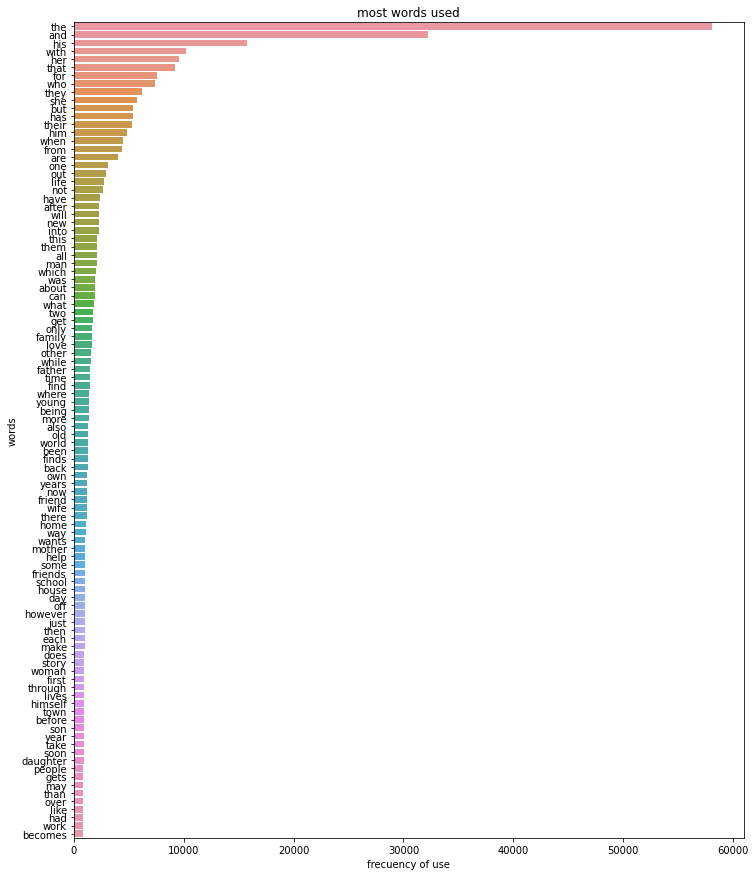

Len of the vocabulary 39428


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


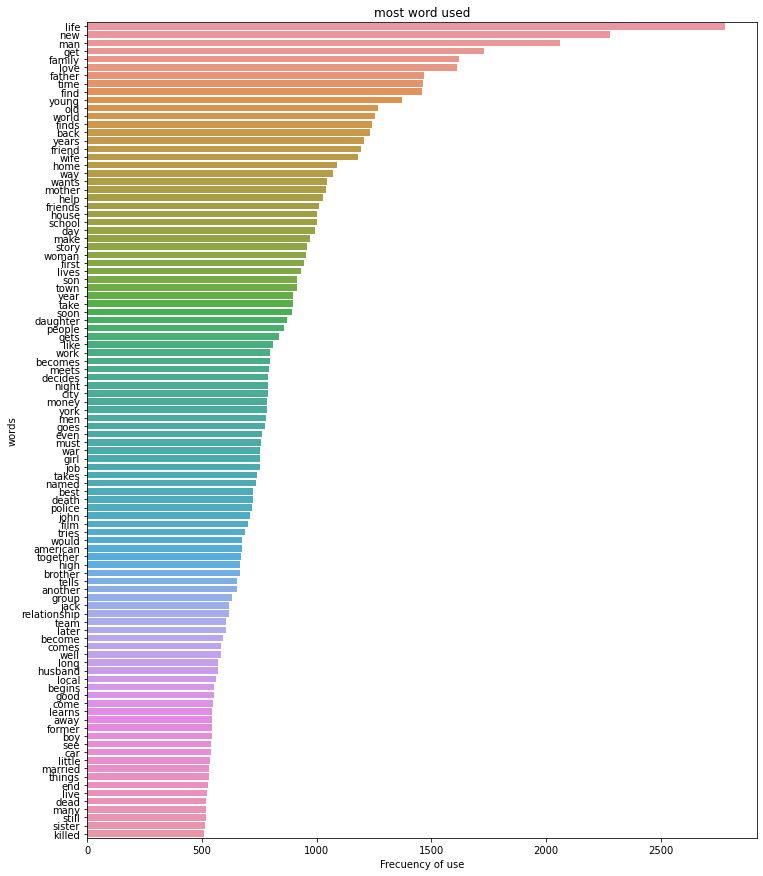

Len of the vocabulary 39373
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


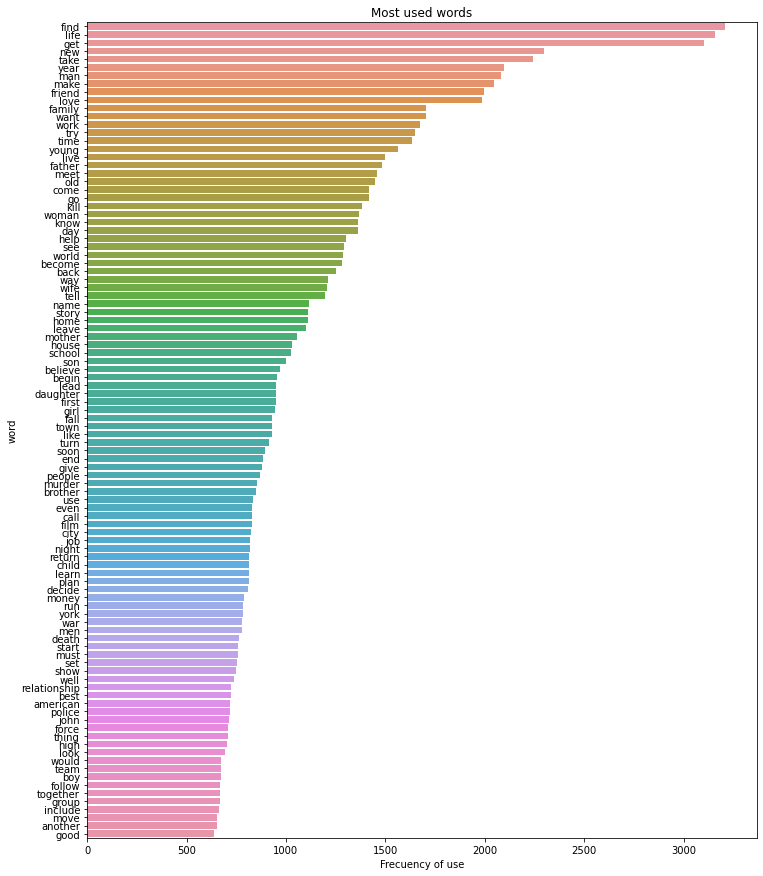

Len of the vocabulary 34211
(7895, 17356)
Len of the vocabulary: 17356


In [ ]:
#2. TEXT PREPROCESSING 
from six import text_type

# 2.1 REMOVE NOISE 
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import sys

def remove_htmltags(text):
    text_prep = re.compile('<.*?>')
    text_prep = re.sub(text_prep, ' ', str(text))
    soup= BeautifulSoup(text_prep)
    text_prep=soup.get_text()
    return text_prep

def remove_special_characters(text): 
    text_prep = re.sub(r'[?|!|\'|"|#]',r'',text)
    text_prep = re.sub(r'[.|,|)|(|\|/]',r' ',text_prep)
    text_prep = text_prep.strip()
    text_prep = text_prep.replace("\n"," ")
    return text_prep


def keep_only_alphabetical_characters(text):
    text_prep = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        if len(alpha_word) > 2:
          text_prep += alpha_word
        text_prep += " "
    text_prep = text_prep.strip()
    return text_prep

dataTraining['plot_trans'] = dataTraining['title'] + " "+ dataTraining['plot'].str.lower()
dataTraining['plot_trans'] = dataTraining['plot_trans'].apply(lambda text:remove_htmltags(text))
dataTraining['plot_trans'] = dataTraining['plot_trans'].apply(lambda text: remove_special_characters(text))
dataTraining['plot_trans'] = dataTraining['plot_trans'].apply(lambda text:keep_only_alphabetical_characters(text))

# Frecuency of use of the words that form the new corpus after preprocessing text
vectorizer = CountVectorizer(analyzer='word')
plot_dtm = vectorizer.fit_transform(dataTraining['plot_trans'])
plots_df = pd.DataFrame(plot_dtm.toarray(), columns=vectorizer.get_feature_names())
freq_plots= plots_df.sum().sort_values( ascending=False)[0:100]
plt.figure(figsize=(12,15)) 
ax=sns.barplot(x=freq_plots.values, y=freq_plots.index)
ax.set(title='most words used', xlabel='frecuency of use', ylabel='words')
plt.show()
print(f'Len of the vocabulary {len(vectorizer.get_feature_names())}')

#Supress stopwords 
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                   'may','also','across','among','beside','however','yet','within',
                   'and','or'])
def remove_stopwords(text, stop_words):
  text_prep = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
  return text_prep.sub(" ", text)
  
dataTraining['plot_trans'] = dataTraining['plot_trans'].apply(lambda text: remove_stopwords(text,stop_words))


# Frecuency of use of the words that form the new corpus after stop_word supression
vectorizer = CountVectorizer(analyzer='word')
plot_dtm = vectorizer.fit_transform(dataTraining['plot_trans'])
plots_df = pd.DataFrame(plot_dtm.toarray(), columns=vectorizer.get_feature_names())
freq_plots= plots_df.sum().sort_values( ascending=False)[0:100]
plt.figure(figsize=(12,15)) 
ax=sns.barplot(x=freq_plots.values, y=freq_plots.index)
ax.set(title='most word used', xlabel='Frecuency of use', ylabel='words')
plt.show()
print(f'Len of the vocabulary {len(vectorizer.get_feature_names())}')

#2.2 LEXICON NORMALIZATION
!pip install textblob
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob, Word
def lemmatizar_con_postag(text):
    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

dataTraining['plot_trans'] = dataTraining['plot_trans'].apply(lambda x: lemmatizar_con_postag(x))

# Frecuency of use of the words that form the new corpus after lemmatization
vectorizer = CountVectorizer(analyzer='word')
plot_dtm = vectorizer.fit_transform(dataTraining['plot_trans'])
plots_df = pd.DataFrame(plot_dtm.toarray(), columns=vectorizer.get_feature_names())
freq_plots= plots_df.sum().sort_values( ascending=False)[0:100]
plt.figure(figsize=(12,15)) 
ax=sns.barplot(x=freq_plots.values, y=freq_plots.index)
ax.set(title='Most used words', xlabel='Frecuency of use', ylabel='word')
plt.show()
print(f'Len of the vocabulary {len(vectorizer.get_feature_names())}')

#2.3 Convert Text to Features (Tokenization)
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,1),min_df=2, max_df=0.7, sublinear_tf=True )
X_dtm = vect.fit_transform(dataTraining['plot_trans'])
filename = 'vectorizer_tfid.pkl'
joblib.dump(vect, filename)
print(X_dtm.shape)
print("Len of the vocabulary:", len(vect.get_feature_names()))


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
import joblib
sentences_list =  dataTraining['plot_trans'].values.tolist() 
tokenizer= tf.keras.preprocessing.text.Tokenizer(num_words=17356,oov_token="<OOV>")
tokenizer.fit_on_texts(sentences_list)
voc_size= len(tokenizer.word_index)
print(voc_size)
training_sequences= tokenizer.texts_to_sequences(sentences_list)
X_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences= training_sequences,padding='post')
filename = 'tokenizer.pkl'
joblib.dump(tokenizer, filename)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
34229


['tokenizer.pkl']

In [ ]:
#This is multilabel model
dataTraining['multilabel_genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['multilabel_genres'])
filename = 'multilabelbinarizer.pkl'
joblib.dump(le, filename)

#split data into a training set and test set.
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_sequences, y_genres, test_size=0.33, random_state=42)




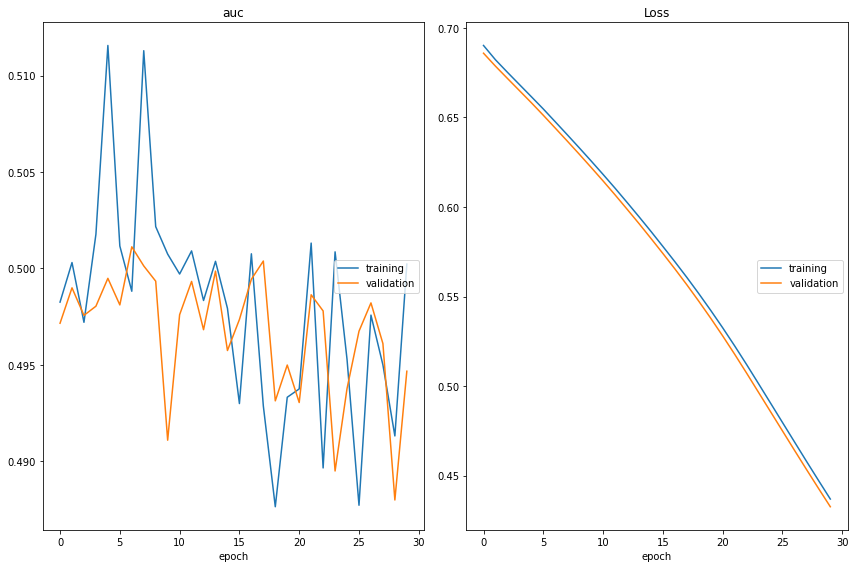

auc
	training         	 (min:    0.488, max:    0.512, cur:    0.500)
	validation       	 (min:    0.488, max:    0.501, cur:    0.495)
Loss
	training         	 (min:    0.437, max:    0.690, cur:    0.437)
	validation       	 (min:    0.433, max:    0.686, cur:    0.433)
82/82 [==============================] - 0s 2ms/step - loss: 0.4326 - auc: 0.4947
[0.4326232671737671, 0.4946713149547577]
The best parameters: {'patience': 2, 'optimizer': 'sgd', 'neurons': 64, 'loss': 'binary_crossentropy', 'epochs': 30, 'dropout': None, 'batch_size': 64, 'activation': 'relu'}


In [ ]:
# Expoermient with Embedding Layer
!pip install  livelossplot 
from livelossplot import PlotLossesKeras
from keras import backend as K
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping

def get_nn_model(optimizer ,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    dropout,
                    loss):
  K.clear_session()
  num_labels=len(y_genres[0])
  print(num_labels)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(voc_size,15))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(neurons, activation=activation))
  if dropout != None:
    model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(num_labels,activation='sigmoid'))
  
  early_stopping = EarlyStopping(monitor="val_loss", patience = patience)
  model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.AUC(multi_label=True,num_labels=num_labels)])
  print(model.summary)
  model.fit(X_train,y_train_genres ,epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test_genres), callbacks=[PlotLossesKeras(), early_stopping])
  print( model.evaluate(X_test, y_test_genres))
  return model

nn_params = {
    'optimizer': ['adam','sgd'],
    'activation': ['relu'],
    'batch_size': [32,64],
    'neurons':[24,48,64,256],
    'epochs':[20,30,50],
    'patience':[2,5],
    'dropout':[None, 0.2],
    'loss':['binary_crossentropy']
}

nn_model = KerasClassifier(build_fn=get_nn_model, verbose=0)
gs=RandomizedSearchCV(nn_model, nn_params, cv=3)
gs.fit(X_train,y_train_genres )

print('The best parameters:', gs.best_params_)
 

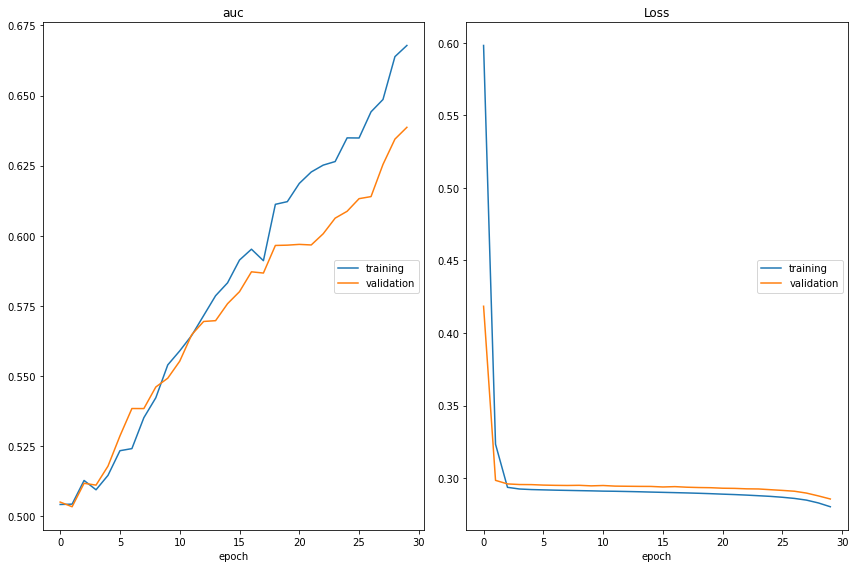

auc
	training         	 (min:    0.504, max:    0.668, cur:    0.668)
	validation       	 (min:    0.503, max:    0.639, cur:    0.639)
Loss
	training         	 (min:    0.280, max:    0.598, cur:    0.280)
	validation       	 (min:    0.286, max:    0.418, cur:    0.286)
82/82 [==============================] - 0s 2ms/step - loss: 0.2855 - auc: 0.6387
[0.2855346202850342, 0.6386716961860657]


In [ ]:
get_nn_model(optimizer='adam',
              neurons=64,
              batch_size=64,
              epochs=30,
              activation='relu',
              patience=2,
              dropout=None,
              loss='binary_crossentropy')